In [1]:
import pickle
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Import modules from the backtester package
from order_generator import BettingAgainstIVOLOrderGenerator
from backtest_engine import EquityBacktestEngine
from metrics import ExtendedMetrics

# first, run python cache_sp500_data.py to prevent caching all universe every run, then run this script
with open('sp500_data.pkl', 'rb') as f:
    sp500_data = pickle.load(f)

if 'SPY' not in sp500_data:
    sample_ticker = list(sp500_data.keys())[0]
    dates = sp500_data[sample_ticker].index
    start_date = dates.min().strftime('%Y-%m-%d')
    end_date = dates.max().strftime('%Y-%m-%d')
    spy_df = yf.download("SPY", start=start_date, end=end_date, auto_adjust=False)
    # keep only the needed columns to mimic the structure in the cache
    spy_df = spy_df[['Adj Close', 'Volume']].copy()
    sp500_data['SPY'] = spy_df

# exclude SPY since that is our benchmark
stock_tickers = [ticker for ticker in sp500_data.keys() if ticker != 'SPY']
prices_dict = {}
for ticker in stock_tickers:
    df = sp500_data[ticker]
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    prices_dict[ticker] = df['Adj Close']


price_df = pd.DataFrame(prices_dict).dropna(how='all')
price_df = price_df.sort_index()
bai_generator = BettingAgainstIVOLOrderGenerator(lookback_period=60, rebalance_frequency='ME', starting_portfolio_value=100_000)
orders = bai_generator.generate_orders(sp500_data)
print(f"Generated {len(orders)} orders.")

[*********************100%***********************]  1 of 1 completed


Buying JNJ on 2010-04-30 00:00:00
Buying L on 2010-04-30 00:00:00
Buying CLX on 2010-04-30 00:00:00
Buying XOM on 2010-04-30 00:00:00
Buying ED on 2010-04-30 00:00:00
Buying PG on 2010-04-30 00:00:00
Buying MO on 2010-04-30 00:00:00
Buying GIS on 2010-04-30 00:00:00
Buying MCD on 2010-04-30 00:00:00
Buying NI on 2010-04-30 00:00:00
Buying SYK on 2010-04-30 00:00:00
Buying SO on 2010-04-30 00:00:00
Buying ERIE on 2010-04-30 00:00:00
Buying IBM on 2010-04-30 00:00:00
Buying CL on 2010-04-30 00:00:00
Buying HPQ on 2010-04-30 00:00:00
Buying WM on 2010-04-30 00:00:00
Buying WMT on 2010-04-30 00:00:00
Buying PEP on 2010-04-30 00:00:00
Buying MMC on 2010-04-30 00:00:00
Buying T on 2010-04-30 00:00:00
Buying CVX on 2010-04-30 00:00:00
Buying CINF on 2010-04-30 00:00:00
Buying BDX on 2010-04-30 00:00:00
Buying WEC on 2010-04-30 00:00:00
Buying AEP on 2010-04-30 00:00:00
Buying CPB on 2010-04-30 00:00:00
Buying ATO on 2010-04-30 00:00:00
Buying HSIC on 2010-04-30 00:00:00
Buying PCG on 2010-04-

In [ ]:
initial_cash = 100_000
engine = EquityBacktestEngine(initial_cash=initial_cash)
backtest_result = engine.run_backtest(orders, price_df)
portfolio_values_df = backtest_result['portfolio_values']

portfolio_returns = portfolio_values_df['Portfolio Value'].pct_change().dropna()

spy_prices = sp500_data['SPY']['Adj Close']
spy_prices.index = pd.to_datetime(spy_prices.index)
spy_prices = spy_prices.sort_index()
spy_returns = spy_prices.pct_change().dropna()

<class 'list'>
[{'date': Timestamp('2010-04-30 00:00:00'), 'type': 'BUY', 'ticker': 'JNJ', 'quantity': 74217}, {'date': Timestamp('2010-04-30 00:00:00'), 'type': 'BUY', 'ticker': 'L', 'quantity': 74217}, {'date': Timestamp('2010-04-30 00:00:00'), 'type': 'BUY', 'ticker': 'CLX', 'quantity': 74217}, {'date': Timestamp('2010-04-30 00:00:00'), 'type': 'BUY', 'ticker': 'XOM', 'quantity': 74217}, {'date': Timestamp('2010-04-30 00:00:00'), 'type': 'BUY', 'ticker': 'ED', 'quantity': 74217}]
2010-01-04 00:00:00: Portfolio Value - 100000.00
2010-01-05 00:00:00: Portfolio Value - 100000.00
2010-01-06 00:00:00: Portfolio Value - 100000.00
2010-01-07 00:00:00: Portfolio Value - 100000.00
2010-01-08 00:00:00: Portfolio Value - 100000.00
2010-01-11 00:00:00: Portfolio Value - 100000.00
2010-01-12 00:00:00: Portfolio Value - 100000.00
2010-01-13 00:00:00: Portfolio Value - 100000.00
2010-01-14 00:00:00: Portfolio Value - 100000.00
2010-01-15 00:00:00: Portfolio Value - 100000.00
2010-01-19 00:00:00: P


Performance Metrics:
Daily Return: 0.011304602342248102
Cumulative Return: 10571.956938341258
Log Return: 0.002619796868665878
Volatility: 6.90262720118047
Sharpe Ratio: 0.4120546724238712
Max Drawdown: -7.490367704932934
VaR 5%: -0.041154272985632206


c:\Users\peter_\anaconda3\envs\data-quality\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


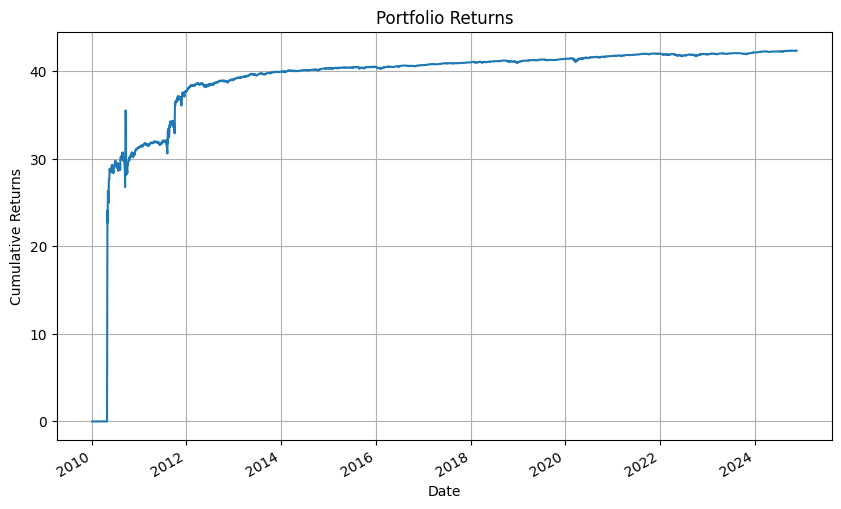

In [3]:
metrics_calculator = ExtendedMetrics()
metrics = metrics_calculator.calculate(portfolio_values_df['Portfolio Value'],
                                        portfolio_returns,
                                        benchmark_returns=spy_returns)
print("\nPerformance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
metrics_calculator.plot_returns(portfolio_returns)